Image Processing from png files into biovolume calculations <br>
Single File workflow and definition of functions: <br>
1- png into image process (enhance contrast,Gaussian blur,edge detection,close small gaps) <br>
2-processed image into segment anything model <br>
3- distance map biovolume calculation<br>
4- ESD calculation from the Largest contour 

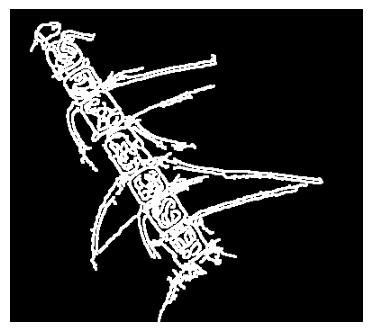

True

In [12]:
##Step 1
#output 3 
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_image(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not loaded, check your path")

    # Step 1: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)

    # Step 2: Apply Gaussian Blur to smooth the image
    blurred_image = cv2.GaussianBlur(enhanced_image, (3, 3), 0)

    # Step 3: Edge detection using Canny
    edges = cv2.Canny(blurred_image, 50, 150)

    # Step 4: Morphological operations to close small gaps in edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Optional: Try to predict line paths using Hough Transform or similar
    # Here, we'll just visualize what we have
    plt.figure(figsize=(10, 5))
    plt.subplot(122)
    plt.imshow(dilated, cmap='gray')
    plt.axis('off')

    plt.show()

    return dilated

# Replace 'path_to_your_chaetoceros_image.jpg' with the path to your actual image
processed_image = enhance_image('C:/Users/kurta/OneDrive - UW/Desktop/deneme/Sikuliaq_23/D20230910T170143_IFCB165_00119.png')

# Save the result
cv2.imwrite('C:/Users/kurta/OneDrive - UW/Desktop/deneme/boundary_images/processed_image_chae119.png', processed_image)


In [64]:
np.save(r'C:\Users\kurta\OneDrive - UW\Desktop\deneme\boundary_images\processed_chae119.npy',processed_image )

In [15]:
#Step-2
#register the model
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/kurta/Downloads/sam_vit_h_4b8939.pth")

In [32]:
#read the saved processed image
processed_image=cv2.imread(r"C:\Users\kurta\OneDrive - UW\Desktop\deneme\boundary_images\processed_image_chae119.png")


In [33]:
from segment_anything import SamPredictor
predictor = SamPredictor(sam)
predictor.set_image(processed_image)
masks, _, _ = predictor.predict()

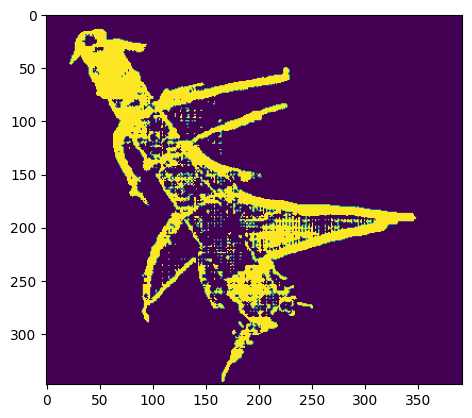

In [35]:
#plot and save the mask2
plt.imshow(masks[2])
sa_chae119=masks[2]
#save as png
file_path=r"C:\Users\kurta\OneDrive - UW\Desktop\deneme\boundary_images\post-SA\sa_chae19.npy"
 #Save the array to a .npy file
np.save(file_path, sa_chae119)


In [3]:
#Step 3
import numpy as np
from scipy.ndimage import distance_transform_edt, binary_fill_holes

def distmap_volume(boundary_image):
    """
    Calculate the volume in pixel cubes of a target with complex closed boundary shape
    indicated in the black and white 2D boundary_image (boundary pixels set to 1).
    
    The volume is derived according to the distance map approach of Moberg and Sosik (2012),
    Limnology and Oceanography: Methods.
    """
    # Calculate distance map
    dist = distance_transform_edt(1 - boundary_image)
    
    # Normalize the distance map to the range [0, 1]
    dist_normalized = dist / np.max(dist)
    
    # Fill holes in the boundary image to mask distance map
    image_fill = binary_fill_holes(boundary_image)
    dist_normalized[~image_fill] = np.nan  # Set distances outside the boundary to NaN
    
    # Add 1 to all distances to align with the original calculation
    dist_normalized += 1
    
    # Find representative transect length
    x = 4 * np.nanmean(dist_normalized) - 2
    
    # Define cross-section correction factors
    # Pyramidal cross-section to interpolated diamond
    c1 = (x**2) / (x**2 + 2*x + 0.5)
    # Diamond to circumscribing circle
    c2 = np.pi / 2
    
    # Calculate final volume applying correction factors to distance map
    volume = c1 * c2 * 2 * np.nansum(dist_normalized)
    
    return volume



In [36]:
#step 4
import cv2

def calculate_abd_from_largest_contour(binary_image):
    """
    Calculate the Area-Based Diameter (ABD) from the largest contour in a binary image, 
    and return the largest contour along with ABD.
    """
    # Ensure the binary image is in uint8 format
    if binary_image.dtype != np.uint8:
        binary_image = binary_image.astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return 0, None  # No contours found
    
    # Identify the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    largest_area = cv2.contourArea(largest_contour)
    
    # Calculate ABD from the largest contour
    abd = 2 * np.sqrt(largest_area / np.pi) if largest_area > 0 else 0
    
    return abd, largest_contour

# Assuming you have loaded your binary_image as described earlier
abd, largest_contour = calculate_abd_from_largest_contour(sa_chae119)
print("ABD:", abd)


ABD: 146.65022724197067


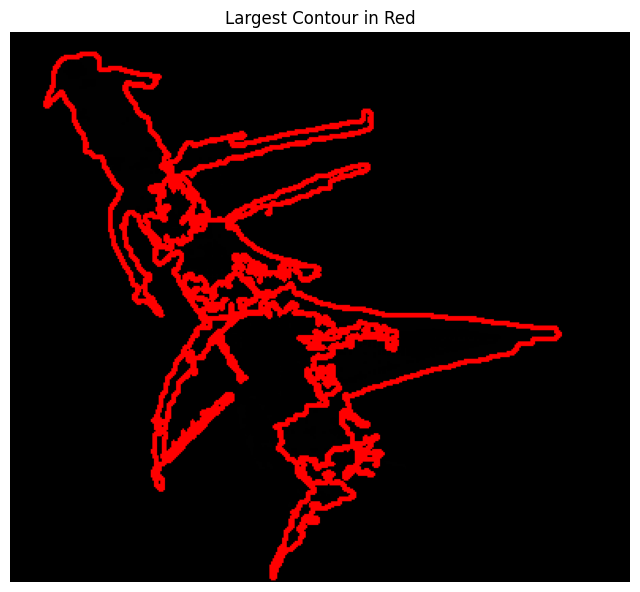

In [61]:
#plotting the largest contour
def plot_largest_contour(binary_image, largest_contour):
    """
    Plot the largest contour on the binary image with a red line.
    """
    # Ensure the binary image is in uint8 format
    if binary_image.dtype != np.uint8:
        binary_image = binary_image.astype(np.uint8)
    
    # Create an RGB version of the binary image for plotting
    image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
    
    # Draw the largest contour with a red line
    cv2.drawContours(image_rgb, [largest_contour], -1, (255, 0, 0), 2)
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title('Largest Contour in Red')
    plt.axis('off')
    plt.show()
# Plot the largest contour
if largest_contour is not None:
    plot_largest_contour(sa_chae119, largest_contour)
else:
    print("No contour found to plot.")

